Need to get hourly or so BTC prices.  

Found this Stackoverflow thread:  
>Actually, you CAN get the whole Bitcoin trades history from Bitcoincharts in CSV format here : > http://api.bitcoincharts.com/v1/csv/

>it is updated twice a day for active exchanges, and there is a few dead exchanges, too.

>EDIT: Since there are no column headers in the CSVs, here's what they are : column 1) the trade's names=None, column 2) the price, column 3) the volume of the trade

  
Downloaded the data for bitstampUSD: 724 Mb unzipped csv.
Let's try

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import autopep8

In [2]:
# Matplotlib setup
from __future__ import print_function, division
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# from plotly.offline import plot, iplot, init_notebook_mode
# import plotly.graph_objs as go

# # Make plotly work with Jupyter notebook
# %matplotlib inline
# init_notebook_mode()

# import cufflinks as cf

# Add error handler that installs cufflinks if this call above fails:
#  ! pip install cufflinks --upgrade

# cf.go_offline()

In [4]:
# Run once to fetch the data and filter it to 2017 only

# ADD CONDITION IF ISPATH to skip over this block

# Add the code to download and unzip the data from this URL:

# http://api.bitcoincharts.com/v1/csv/bitstampUSD.csv.gz (this is the 724Mb file)


# inp = pd.read_csv("data/bitstampUSD.csv",names = ["timestamp","price", "volume"])

# inp["date_time"]= pd.to_datetime(inp["timestamp"], unit='s')\
#                  .dt.tz_localize('UTC')\
#                  .dt.tz_convert('America/New_York')
        
# btc = inp[inp["date_time"]>= "2017-01-01"]
# btc.to_csv("processed_data/bitstampUSD_processed_2017.csv",index=False)
# btc.to_pickle("processed_data/bitstampUSD_processed_2017.p")

In [5]:
processed_path = "processed_data/bitstampUSD_processed_2017.p"
btc = pd.read_pickle(processed_path)

In [6]:
btc.head()
# btc.dtypes

,timestamp,price,volume,date_time
10240699,1483228868,966.34,1.46000,2016-12-31 19:01:08-05:00
10240700,1483228873,966.34,1.32000,2016-12-31 19:01:13-05:00
10240701,1483228888,966.34,4.83000,2016-12-31 19:01:28-05:00
10240702,1483228926,966.16,2.38000,2016-12-31 19:02:06-05:00
10240703,1483228926,966.36,2.20029,2016-12-31 19:02:06-05:00


In [7]:
# Extract the date, add date time to index and cut out the end of 2016 
btc["date"] = btc.date_time.dt.date
btc.index = btc.date_time
btc = btc["2017"]

#### How did the price development look like in 2017?

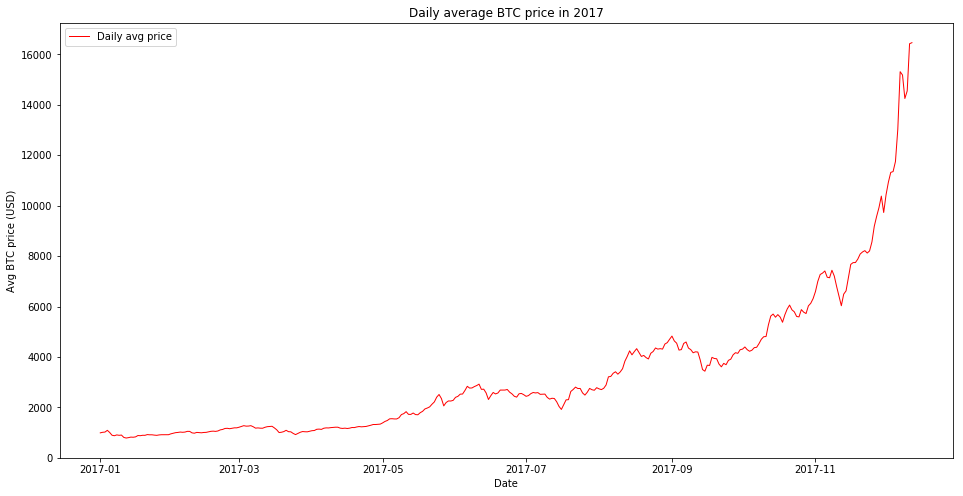

In [9]:
# Make the daily/hourly plot
btc = btc.sort_values("timestamp")
df = btc.groupby("date")["price"].agg(['mean']).rename(columns={'mean': 'price'})

plt.figure(num=1, figsize=(16, 8)) 
plt.plot(df.index, df["price"], linewidth=1,
         color="red", label=r"Daily avg price")
plt.xlabel(r"Date")
plt.ylabel(r"Avg BTC price (USD)")
plt.title(r"Daily average BTC price in 2017")


plt.legend(loc="upper left")

plt.show()

#### Did the price increase or decrease at the close of the day?

In [10]:
# Add the time aggregation and OHLC funciton


def time_precision(series, precision):
    """
    Returns the date time series with a date time value floored to the 
    specified freq string
    """
    return (pd.DatetimeIndex(series)).floor(precision)


def make_ohlc(df, datetime_col, price_col, time_granularity):
    """
    Calculates the data for an OHLC chart from a df with a date_time and
    price columns, with intervals of time_granularity. Returns a DataFrame.
    """
    
    df = df.sort_values(datetime_col)    
    df["time_bracket"] = df[datetime_col].map(
        lambda x: time_precision(x, time_granularity))

    btc_ohlc = df.groupby("time_bracket")[price_col]\
        .agg(["first", "max", "min", "last", "median"])\
        .rename(columns={'first': 'open', 'max': 'high', "min": "low", "last": "close"})

    conditions = [(btc_ohlc['open'] <= btc_ohlc['close']),
                  (btc_ohlc['open'] > btc_ohlc['close'])]

    choices = ["up", "down"]

    btc_ohlc['price_change_label'] = np.select(conditions, choices)

    btc_ohlc["price_change_pct"] = 100 * \
        (btc_ohlc["close"] / btc_ohlc["open"] - 1)

    return (btc_ohlc)

In [11]:
btc_ohlc_24h = make_ohlc(btc,"date_time","price","1d")
btc_ohlc_6h = make_ohlc(btc,"date_time","price","6h")

In [12]:
btc_ohlc_6h.head(5)

,open,high,low,close,median,price_change_label,price_change_pct
time_bracket,,,,,,,
2017-01-01 00:00:00-05:00,963.02,974.77,962.80,973.98,968.72,up,1.138086
2017-01-01 06:00:00-05:00,973.98,992.99,970.72,992.99,977.66,up,1.951785
2017-01-01 12:00:00-05:00,992.98,1004.88,981.57,1002.50,999.00,up,0.958730
2017-01-01 18:00:00-05:00,1002.40,1005.75,994.39,1005.73,999.50,up,0.332203
2017-01-02 00:00:00-05:00,1005.48,1024.00,1002.80,1020.00,1011.00,up,1.444086


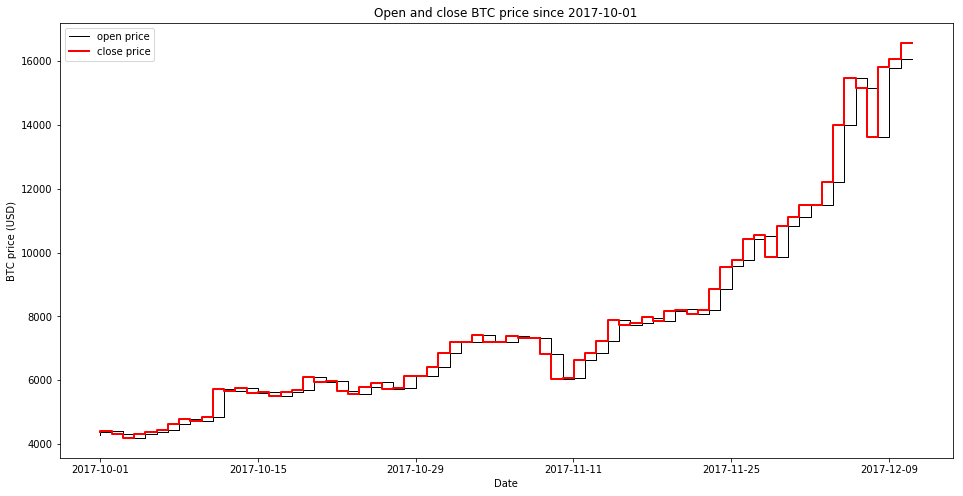

In [13]:
# Make the o-c plot
start_date = "2017-10-01"
df = btc_ohlc_24h[pd.to_datetime(start_date).date():]

plt.figure(num=1, figsize=(16, 8)) 
plt.step(df.index, df["open"], linewidth=1,
         color="black", label=r"open price")
plt.xlabel(r"Date")
plt.ylabel(r"BTC price (USD)")
plt.title(r"Open and close BTC price since "+start_date)
plt.step(df.index, df["close"], linewidth=2,
         color="red", label=r"close price")
plt.legend(loc="upper left")
plt.show()

In [383]:
btc_ohlc_24h.groupby("price_change_label")["price_change_label"].count()

price_change_label
down    130
up      216
Name: price_change_label, dtype: int64

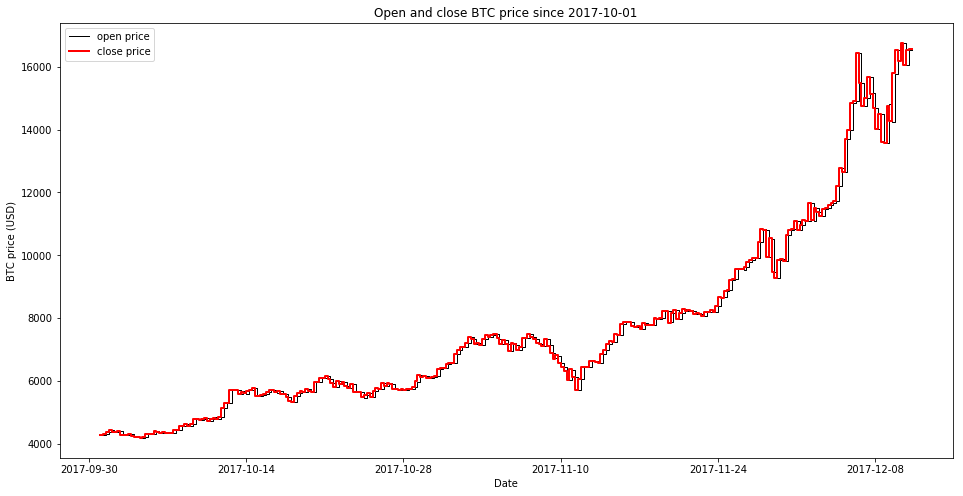

In [407]:
# Make the o-c plot
start_date = "2017-10-01"
df = btc_ohlc_6h[pd.to_datetime(start_date).date():]

plt.figure(num=1, figsize=(16, 8)) 
plt.step(df.index, df["open"], linewidth=1,
         color="black", label=r"open price")
plt.xlabel(r"Date")
plt.ylabel(r"BTC price (USD)")
plt.title(r"Open and close BTC price since "+start_date)
plt.step(df.index, df["close"], linewidth=2,
         color="red", label=r"close price")
plt.legend(loc="upper left")
plt.show()

In [408]:
btc_ohlc_24h.to_csv("processed_data/btc_ohlc_24.csv")
btc_ohlc_6h.to_csv("processed_data/btc_ohlc_6h.csv")

## The time aggregated DF used later for joining with Twitter is defined here:

In [183]:
time_aggr = "12h" ## Definition of the used time precision!
btc_ohlc = make_ohlc(btc,"date_time","price",time_aggr)

In [184]:
btc_ohlc.head(5)

,open,high,low,close,median,price_change_label,price_change_pct
time_bracket,,,,,,,
2017-01-01 00:00:00-05:00,963.02,992.99,962.80,992.99,975.400,up,3.112085
2017-01-01 12:00:00-05:00,992.98,1005.75,981.57,1005.73,999.170,up,1.284014
2017-01-02 00:00:00-05:00,1005.48,1032.00,998.72,1025.70,1020.005,up,2.010980
2017-01-02 12:00:00-05:00,1025.70,1029.92,990.01,1023.57,1013.000,down,-0.207663
2017-01-03 00:00:00-05:00,1023.59,1026.50,1009.08,1020.98,1018.890,down,-0.254985


### Get the Tweets

In [185]:
twt_path = "data/tweets2017.csv"
twt = pd.read_csv(twt_path)
twt.shape

(49212, 2)

In [186]:
twt.head(5)

,tweet,timestamp
0,Investment Firm Will Use Bitcoin To Avoid US S...,2017-03-31 20:00:05
1,#Anarchist #Bitcoin Coder Amir Taaki Wound Up ...,2017-03-31 20:28:19
2,【仮想通貨】日本版 Bitcoin 、Monacoinでできること - NAVER まとめ ...,2017-03-31 21:04:50
3,How The Technology Behind Bitcoin Is Going To ...,2017-03-31 21:19:49
4,Federal Reserve official warns of digital curr...,2017-03-31 22:08:03


### Question to clarify - what is the timezone of the twitter timestamps? What is the timezone of the bitcoin price data?

#### Clean the tweets from URLS, non-english characters, and duplicates

In [187]:
def isEnglish(s):
    """Checks if a string contains ASCII characters only.
    Source: https://stackoverflow.com/a/27084708/8066374
    """
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [188]:
# Clean the tweets
twt["tweet_proc"] = twt["tweet"].str.replace("https?://.*","") # remove all urls
twt["tweet_proc"] = twt["tweet_proc"].str.replace("’|#","") # remove non-unicode apostrophe and also hashtag sign
twt = twt[twt["tweet_proc"].str.len() >= 3] # retain only the tweets with more than 3 remaining characters
twt["is_english"] = twt["tweet_proc"].map(isEnglish)

In [189]:
twt.head(5)

,tweet,timestamp,tweet_proc,is_english
0,Investment Firm Will Use Bitcoin To Avoid US S...,2017-03-31 20:00:05,Investment Firm Will Use Bitcoin To Avoid US S...,True
1,#Anarchist #Bitcoin Coder Amir Taaki Wound Up ...,2017-03-31 20:28:19,Anarchist Bitcoin Coder Amir Taaki Wound Up Fi...,True
2,【仮想通貨】日本版 Bitcoin 、Monacoinでできること - NAVER まとめ ...,2017-03-31 21:04:50,【仮想通貨】日本版 Bitcoin 、Monacoinでできること - NAVER まとめ,False
3,How The Technology Behind Bitcoin Is Going To ...,2017-03-31 21:19:49,How The Technology Behind Bitcoin Is Going To ...,True
4,Federal Reserve official warns of digital curr...,2017-03-31 22:08:03,Federal Reserve official warns of digital curr...,True


In [190]:
twt.groupby(["is_english"])["tweet"].count()

is_english
False     8404
True     39725
Name: tweet, dtype: int64

Removed 8404 tweets with non-ascii characters to prepare the data for VADER sentiment analysis

In [191]:
twt_clean = twt[twt["is_english"]==True]

In [192]:
twt_clean = twt_clean.drop_duplicates("tweet_proc")

In [193]:
twt_clean.shape

(21649, 4)

Only 21.6k tweets remain after the cleaning step

#### Extract sentiment using NLTK and VADER

In [194]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

In [195]:
print(twt_clean.loc[3,'tweet_proc'])
print(sid.polarity_scores(twt_clean.loc[3,'tweet_proc']))

How The Technology Behind Bitcoin Is Going To Change The Lives Of The Bottom Billion 
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [196]:
twt_clean["sid"] = twt_clean["tweet_proc"].map(lambda x: sid.polarity_scores(x))

In [197]:
twt_clean = pd.concat([twt_clean.drop(["sid","tweet","is_english"], axis=1), 
                       twt_clean["sid"].apply(pd.Series)], axis=1)

In [198]:
twt_clean.head(10)

,timestamp,tweet_proc,compound,neg,neu,pos
0,2017-03-31 20:00:05,Investment Firm Will Use Bitcoin To Avoid US S...,-0.2960,0.180,0.820,0.000
1,2017-03-31 20:28:19,Anarchist Bitcoin Coder Amir Taaki Wound Up Fi...,-0.3612,0.152,0.848,0.000
3,2017-03-31 21:19:49,How The Technology Behind Bitcoin Is Going To ...,0.0000,0.000,1.000,0.000
4,2017-03-31 22:08:03,Federal Reserve official warns of digital curr...,-0.3612,0.368,0.632,0.000
5,2017-03-31 22:13:59,Bitcoin : 'Blood Diamonds' Of The Digital Era ...,0.1759,0.145,0.639,0.217
6,2017-03-31 22:18:00,A Plan to Save Blockchain Democracy From Bitco...,-0.1779,0.277,0.496,0.227
7,2017-03-31 22:30:18,Digital asset exchange ShapeShift raises $10.4...,0.3612,0.000,0.762,0.238
8,2017-03-31 22:31:14,How an Anarchist Bitcoin Coder Found Himself F...,-0.3612,0.200,0.800,0.000
11,2017-04-01 00:03:18,Reg now behind invisible HTML5 Bitcoin paywall,0.0000,0.000,1.000,0.000
13,2017-04-01 01:03:10,Rising value of ethereum Turning a corner? Is ...,0.4137,0.000,0.784,0.216


#### Visualize the daily sentiment over time

In [199]:
twt_clean.head(1)

,timestamp,tweet_proc,compound,neg,neu,pos
0,2017-03-31 20:00:05,Investment Firm Will Use Bitcoin To Avoid US S...,-0.296,0.18,0.82,0.0


In [200]:
# Extract time components 
twt_clean["date_time"] = pd.to_datetime(twt_clean["timestamp"])
# twt_clean["date"] = twt_clean["date_time"].dt.date

# Add the time granularity required for the join with the price data
twt_clean["time_bracket"] = (pd.DatetimeIndex(twt_clean["date_time"],tz="America/New_York")).floor(time_aggr)

# Get daily total for the VADER scores
twt_clean_agg = twt_clean[["time_bracket","neg","pos","compound"]].groupby(["time_bracket"]).sum()
twt_clean_agg.head()


,neg,pos,compound
time_bracket,,,
2017-03-31 12:00:00-04:00,1.322,0.682,-1.0204
2017-04-01 00:00:00-04:00,3.716,4.041,0.6680
2017-04-01 12:00:00-04:00,1.805,2.793,1.7499
2017-04-02 00:00:00-04:00,1.734,2.065,0.5411
2017-04-02 12:00:00-04:00,1.619,4.069,4.0718


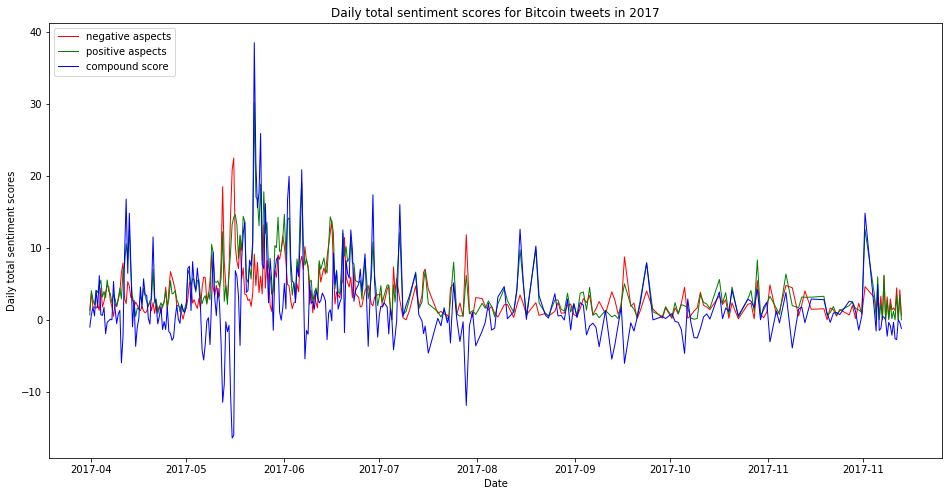

In [201]:
# Make a line plot
df = twt_clean_agg

plt.figure(num=1, figsize=(16, 8)) 
plt.plot(df.index, df["neg"], linewidth=1,
         color="red", label=r"negative aspects")
plt.plot(df.index, df["pos"], linewidth=1,
         color="green", label=r"positive aspects")
plt.plot(df.index, df["compound"], linewidth=1,
         color="blue", label=r"compound score")
plt.xlabel(r"Date")
plt.ylabel(r"Daily total sentiment scores")
plt.title(r"Daily total sentiment scores for Bitcoin tweets in 2017")


# plt.plot(btc_daily_avg["date"], btc_daily_avg["price"], linewidth=1,
#          color="blue", label=r"daily avg price")

plt.legend(loc="upper left")

plt.show()

#### Correlate the daily compound sentiment with the price change direction

In [202]:
twt_clean_agg.head()

,neg,pos,compound
time_bracket,,,
2017-03-31 12:00:00-04:00,1.322,0.682,-1.0204
2017-04-01 00:00:00-04:00,3.716,4.041,0.6680
2017-04-01 12:00:00-04:00,1.805,2.793,1.7499
2017-04-02 00:00:00-04:00,1.734,2.065,0.5411
2017-04-02 12:00:00-04:00,1.619,4.069,4.0718


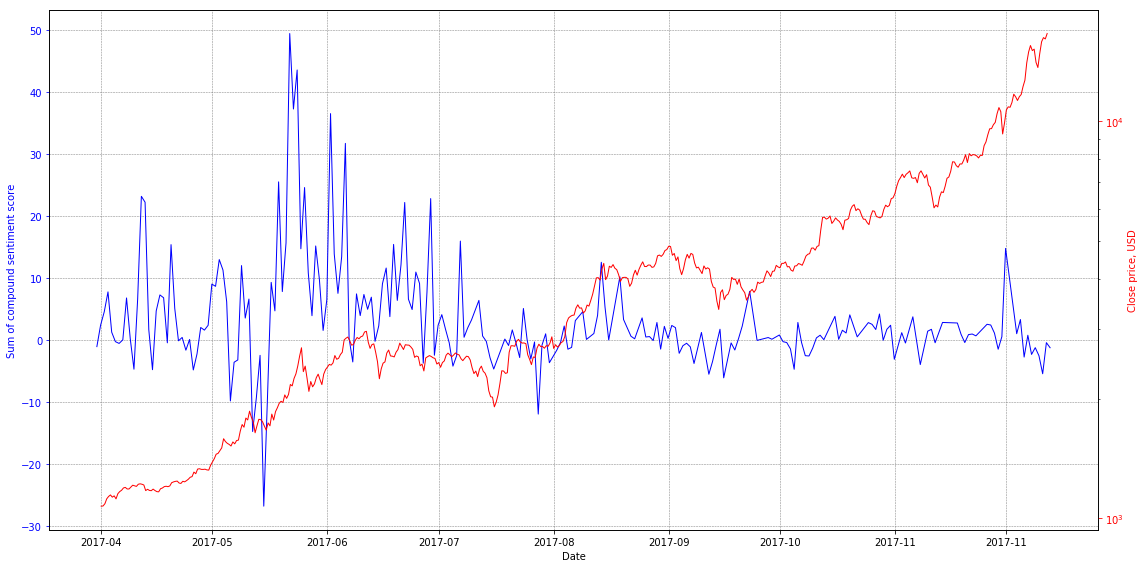

In [203]:
df1 = twt_clean_agg[pd.to_datetime("2017-04-01").date():]
df2 = btc_ohlc[pd.to_datetime("2017-04-01").date():]

fig, ax1 = plt.subplots(figsize=(16, 8))
ax1.plot(twt_clean_daily.index, twt_clean_daily["compound"], linewidth=1,color="blue")
ax1.set_xlabel('Date')

# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Sum of compound sentiment score', color='blue')
ax1.tick_params('y', colors='blue')
ax1.grid(color='grey', linestyle='--', linewidth=.5)

ax2 = ax1.twinx()

ax2.plot(df2.index, df2["close"], linewidth=1,color="red")
ax2.set_ylabel('Close price, USD', color='red')
ax2.tick_params('y', colors='red')
ax2.set_yscale("log", nonposy='clip')

# ax3 = ax1.twinx()
# ax3 = ax1.twiny()
# ax3.plot(twt_clean_daily.index,np.repeat(0,len(twt_clean_daily.index)),
#          linewidth=1,color="black")

fig.tight_layout()
plt.show()

In [204]:
print(btc_ohlc.head(1))
print(twt_clean_agg.head(1))

                             open    high    low   close  median  \
time_bracket                                                       
2017-01-01 00:00:00-05:00  963.02  992.99  962.8  992.99   975.4   

                          price_change_label  price_change_pct  
time_bracket                                                    
2017-01-01 00:00:00-05:00                 up          3.112085  
                             neg    pos  compound
time_bracket                                     
2017-03-31 12:00:00-04:00  1.322  0.682   -1.0204


In [205]:
df1 = twt_clean_agg[pd.to_datetime("2017-04-01").date():]
df2 = btc_ohlc[pd.to_datetime("2017-04-01").date():]

btc_twt = pd.merge(df2.reset_index(),df1.reset_index(),"left")
btc_twt.shape

(511, 11)

In [206]:
# Check the periods with missing Twitter data
btc_twt[btc_twt.pos.isnull()].shape

(190, 11)

### Add features for price change in the previous and past period

In [207]:
btc_twt["price_change_pct_prev_period"] = btc_twt["price_change_pct"].shift(1)
btc_twt["price_change_pct_next_period"] = btc_twt["price_change_pct"].shift(-1)
btc_twt.head(3)

,time_bracket,open,high,low,close,median,price_change_label,price_change_pct,neg,pos,compound,price_change_pct_prev_period,price_change_pct_next_period
0,2017-04-01 00:00:00-04:00,1069.15,1097.0,1065.50,1073.65,1083.74,up,0.420895,3.716,4.041,0.6680,NaN,0.101520
1,2017-04-01 12:00:00-04:00,1073.68,1085.0,1061.64,1074.77,1073.04,up,0.101520,1.805,2.793,1.7499,0.420895,1.324004
2,2017-04-02 00:00:00-04:00,1074.77,1089.0,1066.49,1089.00,1076.58,up,1.324004,1.734,2.065,0.5411,0.101520,2.892562


### There are some days with no tweets in our dataset: decide what to do - remove or impute!

In [208]:
# Filter out the days with no twitter sentiment
btc_twt = btc_twt[btc_twt["compound"].notnull()]
btc_twt.shape

(321, 13)

221 daily observations remain if NaN twitter days are ignored

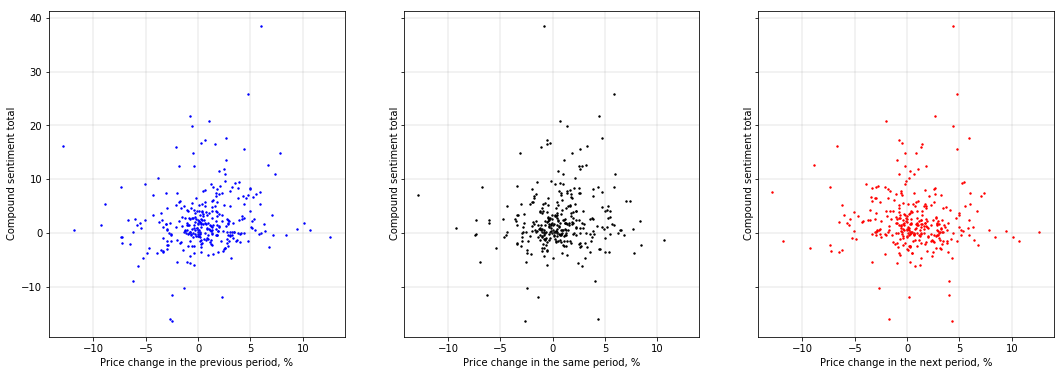

In [209]:
df = btc_twt

# fig, ax1 = plt.subplots(figsize=(8, 8))
fig, ((ax3, ax1, ax2)) = plt.subplots(1,3, sharex=True, sharey=True,figsize=(18, 6))

ax1.scatter(df["price_change_pct"], df["compound"], color="black",s=2)
ax1.set_xlabel('Price change in the same period, %')
ax1.set_ylabel('Compound sentiment total')
ax1.grid(color='grey', linestyle='-', linewidth=0.2)

ax2.scatter(df["price_change_pct_next_period"], df["compound"], color="red",s=2)
ax2.set_xlabel('Price change in the next period, %')
ax2.set_ylabel('Compound sentiment total')
ax2.grid(color='grey', linestyle='-', linewidth=0.2)

ax3.scatter(df["price_change_pct_prev_period"], df["compound"], color="blue",s=2)
ax3.set_xlabel('Price change in the previous period, %')
ax3.set_ylabel('Compound sentiment total')
ax3.grid(color='grey', linestyle='-', linewidth=0.2)

plt.show()

In [ ]:
### Check the correlations

In [215]:
btc_twt[["price_change_pct_prev_period","price_change_pct","price_change_pct_next_period",
         "compound","pos","neg"]].corr()

,price_change_pct_prev_period,price_change_pct,price_change_pct_next_period,compound,pos,neg
price_change_pct_prev_period,1.000000,0.097516,-0.031244,0.164141,0.061595,-0.067275
price_change_pct,0.097516,1.000000,0.081120,0.094282,0.003397,-0.089486
price_change_pct_next_period,-0.031244,0.081120,1.000000,-0.014117,-0.000686,0.001027
compound,0.164141,0.094282,-0.014117,1.000000,0.628429,-0.092628
pos,0.061595,0.003397,-0.000686,0.628429,1.000000,0.704598
neg,-0.067275,-0.089486,0.001027,-0.092628,0.704598,1.000000


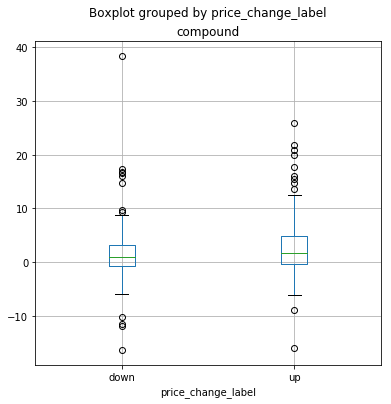

In [210]:
btc_twt.boxplot(column='compound',by='price_change_label',figsize=(6, 6))

### Next steps
  
Dima  
1. Get numeric feature for the price (rolling X hours) - daily and time-period (make function)

Liam
2. Get more Twitter data (to close the days with the gaps) - try switching off Top Tweets
3. Get more Twitter data - from "news" 

Tomorrow
4. Inspect correlations between sentiment and price response (also time-shifted)
5. Maybe - if we see correlation - come up with a model to predict the response

Optional
1. Word frequency distribution from the tweets (also separately for positive and negative tweets)

### Reference

https://pandas.pydata.org/pandas-docs/stable/index.html  
http://mple.m-artwork.eu/tutorial  
Pandas Ifelse selection https://stackoverflow.com/a/19913845/8066374  
NLTK & Vader http://www.nltk.org/howto/sentiment.html  
Pandas dict to columns https://stackoverflow.com/questions/38231591/splitting-dictionary-list-inside-a-pandas-column-into-separate-columns  
Matplotlib multiple axes https://matplotlib.org/examples/api/two_scales.html